In [192]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

sns.set_style("darkgrid")
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [193]:
# Read the data
X = pd.read_csv('home-data-for-ml-course/train.csv', index_col='Id') 


In [194]:
# Print summary statistics in next line
print(X.describe())
X.columns

        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   181.066207   456.098091   161.319273  ..

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [195]:
# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y =X[['SalePrice']]


In [196]:
#split data to numeric and categorical
numeric_c = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).copy()

print(numeric_c.columns)

disc_num_var = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont_num_var = []
for i in numeric_c.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

#categorical
cat_train = X.select_dtypes(include=['object']).copy()
cat_train['MSSubClass'] = X['MSSubClass']   #MSSubClass is nominal
print(cat_train.columns)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'Central

**Univariate Analysis** : Examine the distribution of individual features.

- Histograms, box plots, and frequency tables.

/var/folders/jh/x3pzkf253nz6__d6tfg4p4200000gn/T/ipykernel_2261/870985102.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numeric_c.loc[:,col].dropna(), kde=False)


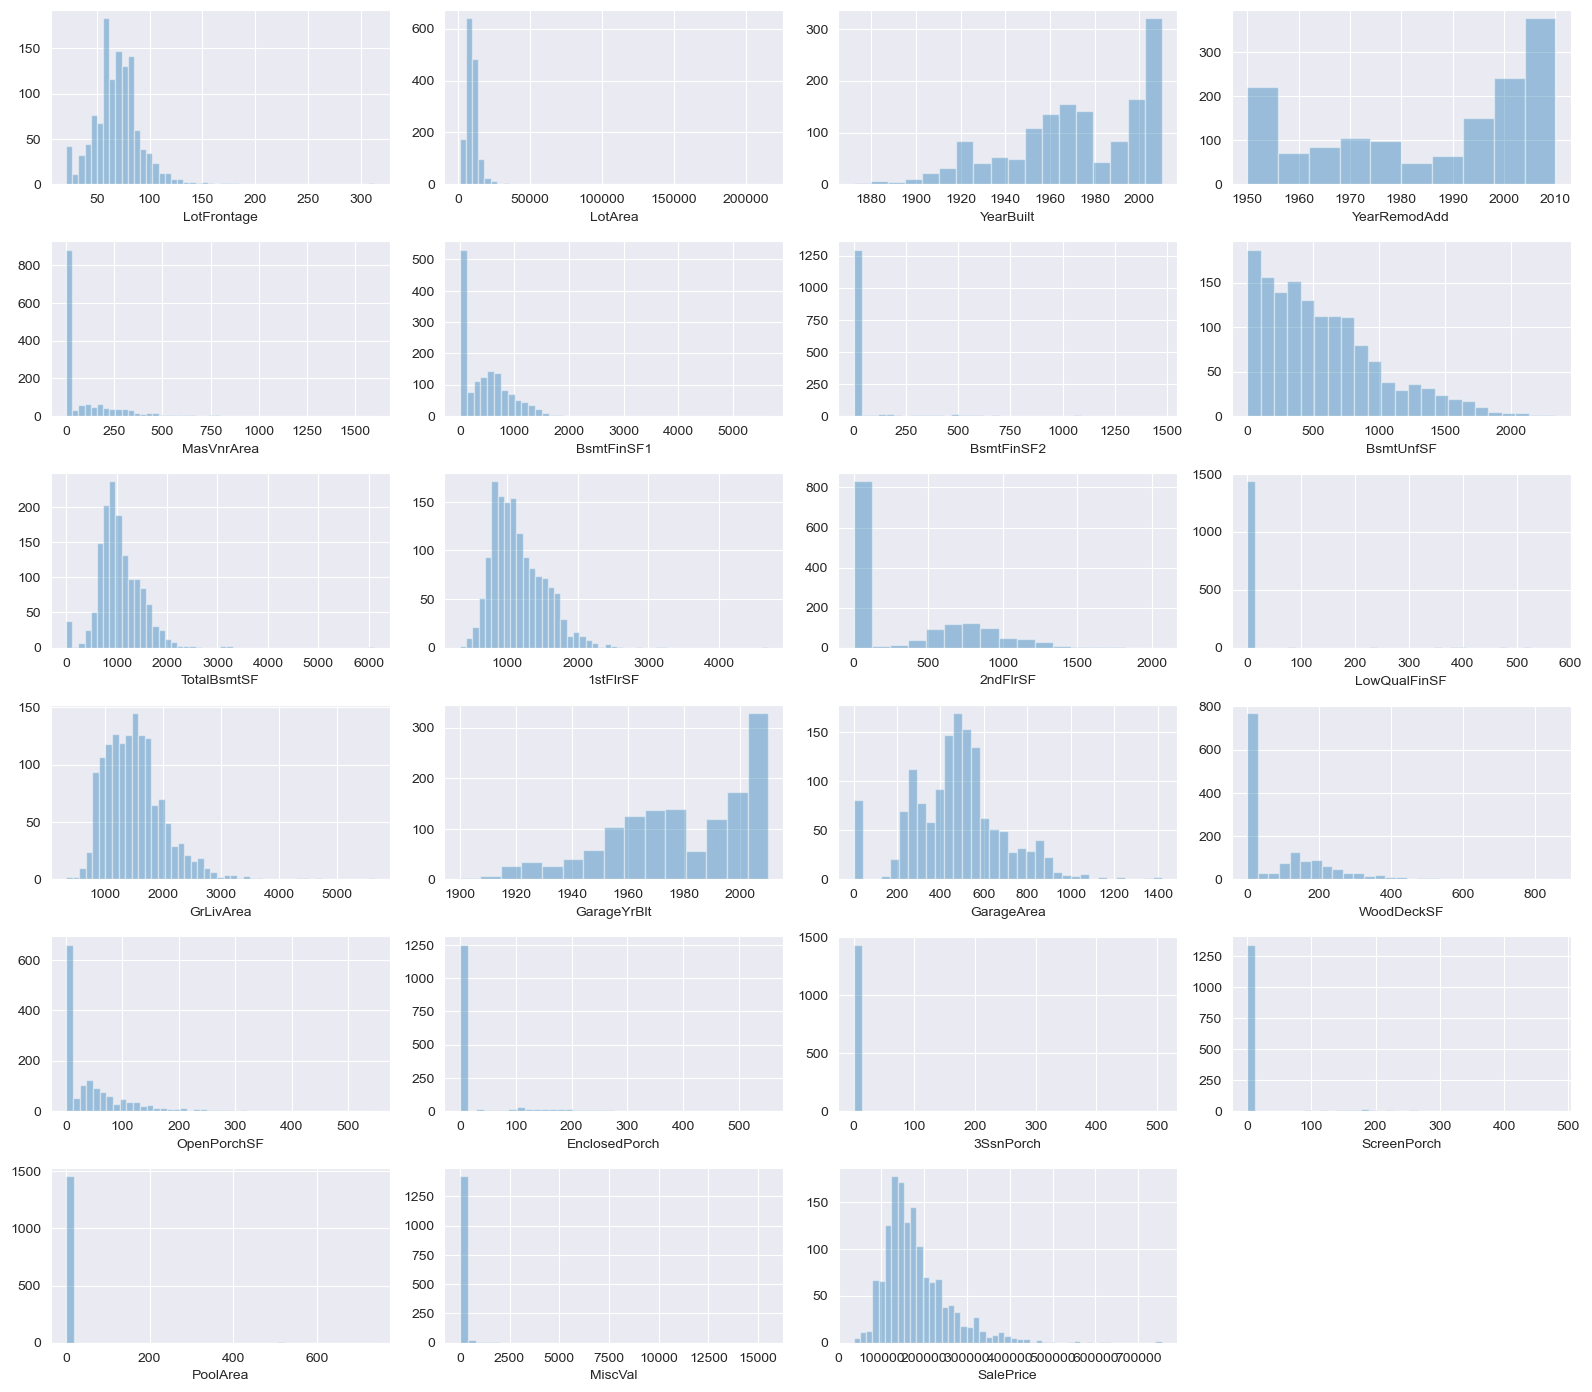

In [197]:
# distribution for continious
fig = plt.figure(figsize=(16,14))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.distplot(numeric_c.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

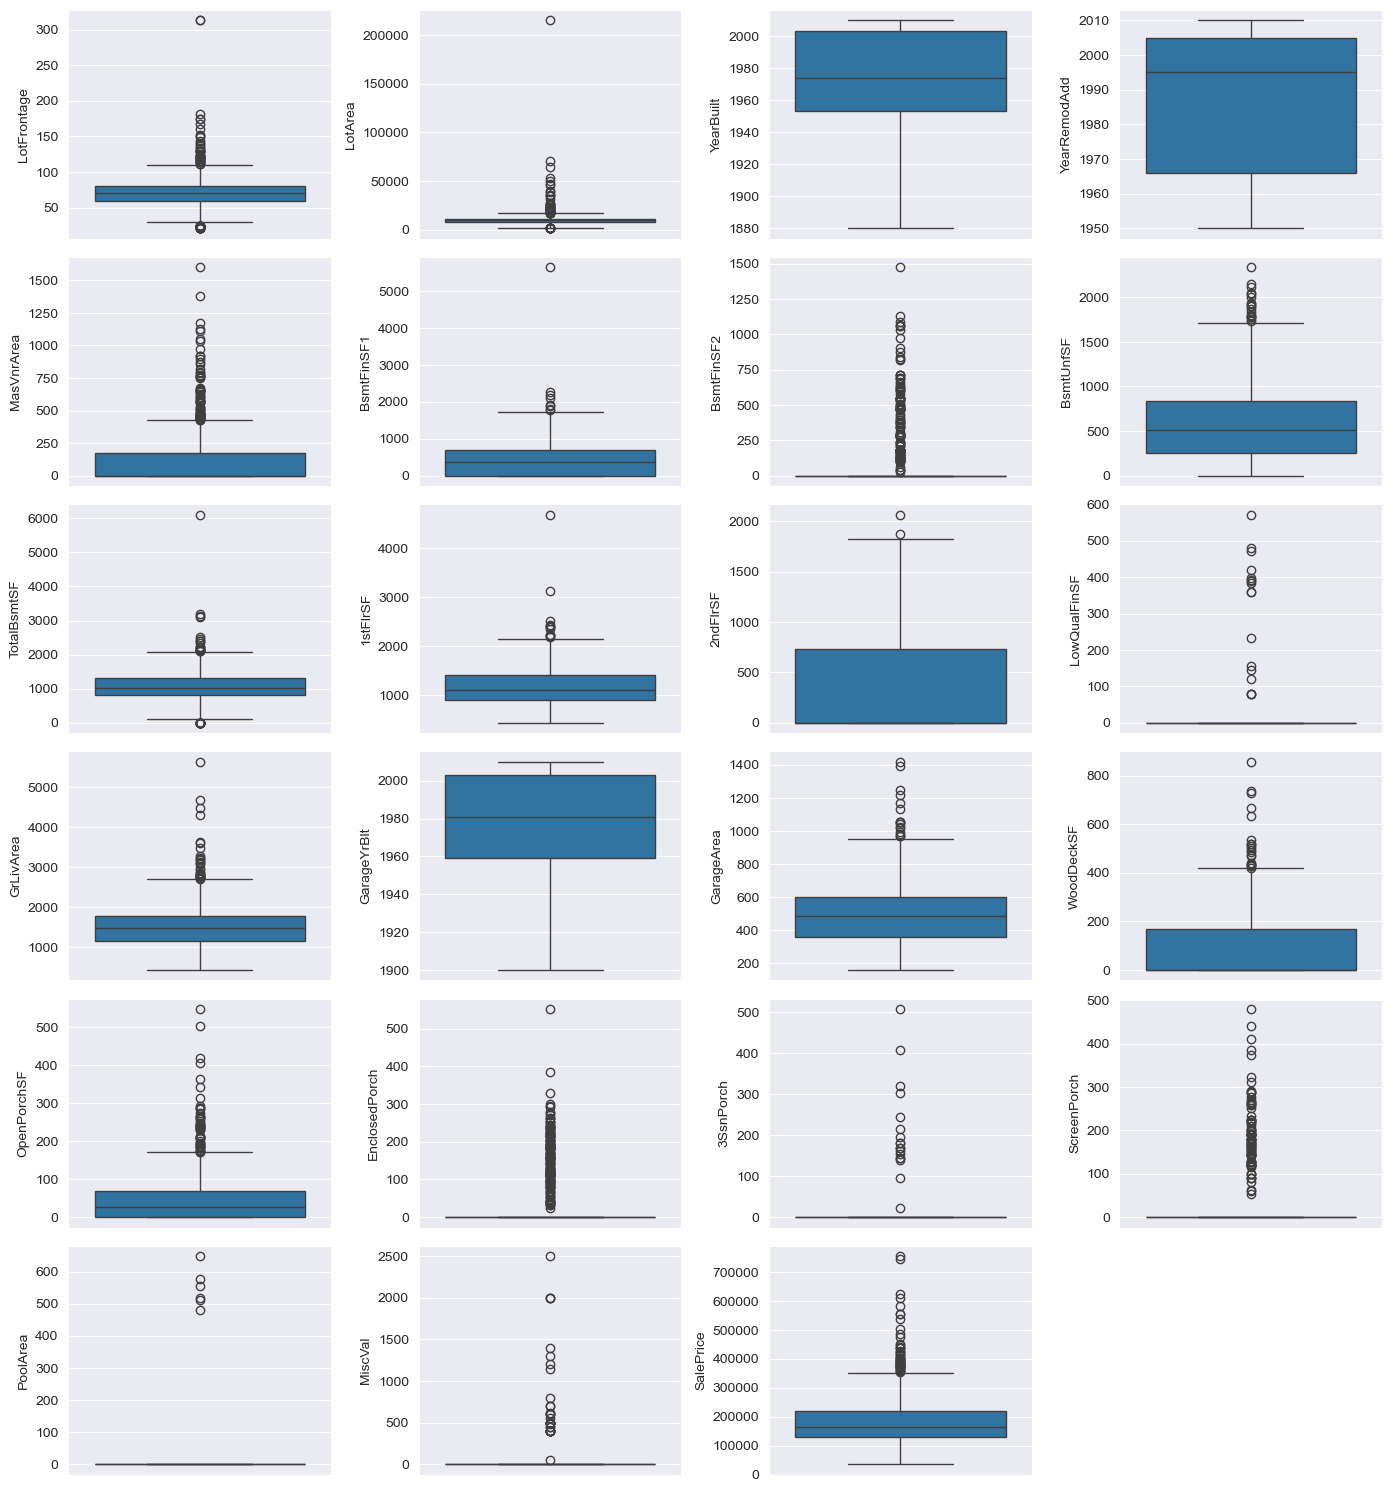

In [198]:
#boxplot 
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.boxplot(y=col, data=numeric_c.dropna())
fig.tight_layout(pad=1.0)

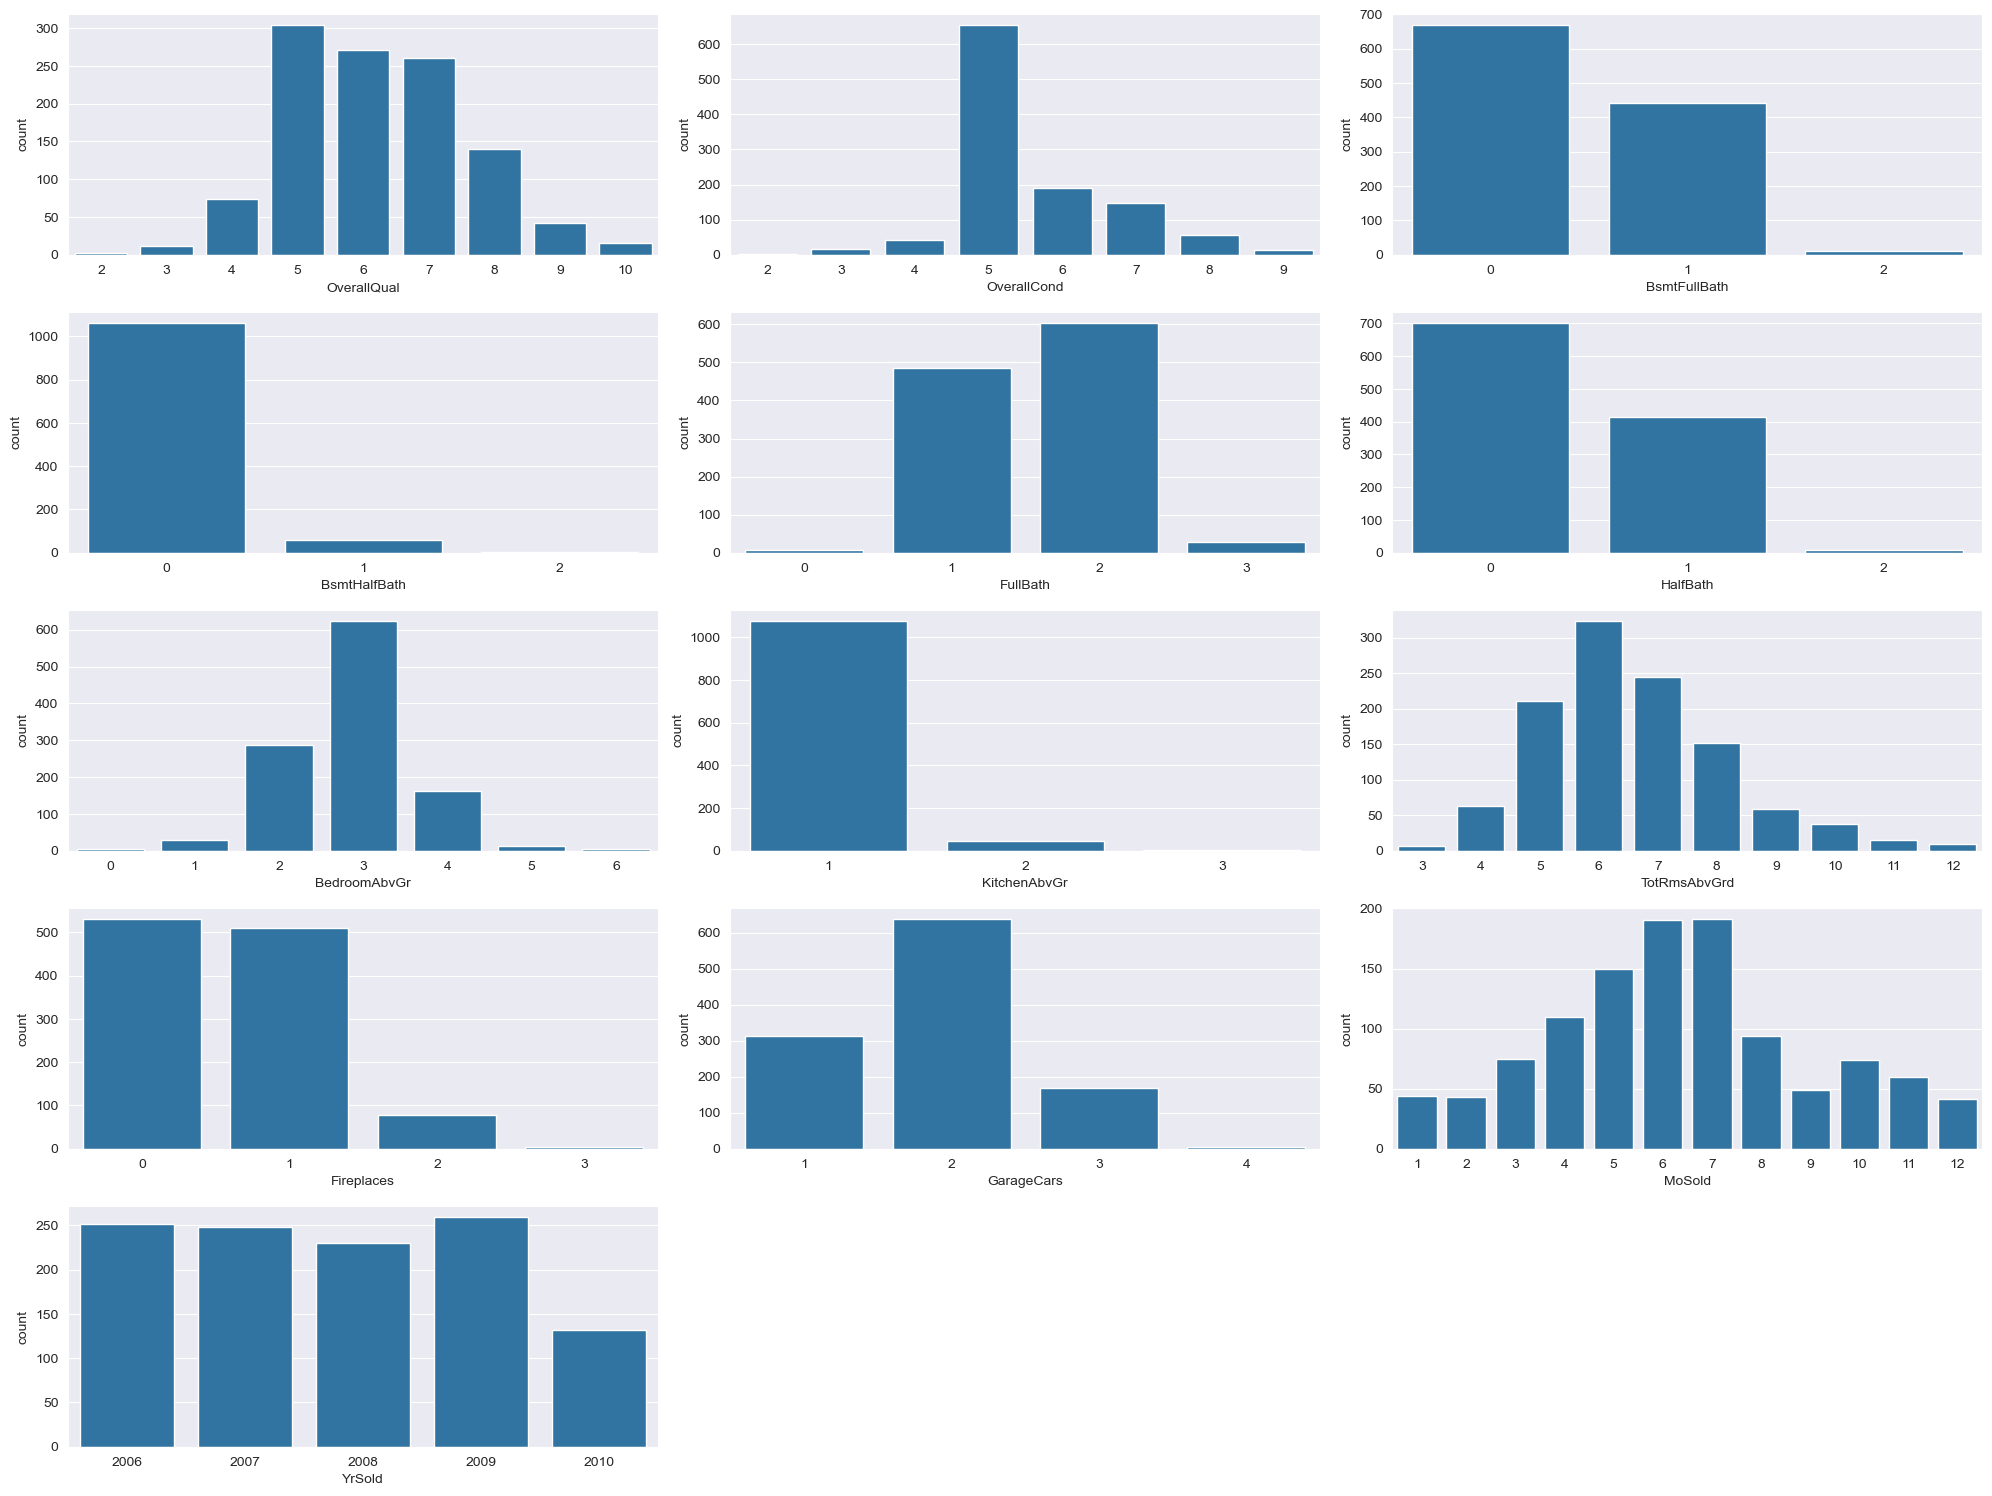

In [199]:
#plot for discrete
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(disc_num_var):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=numeric_c.dropna())
fig.tight_layout(pad=1.0)

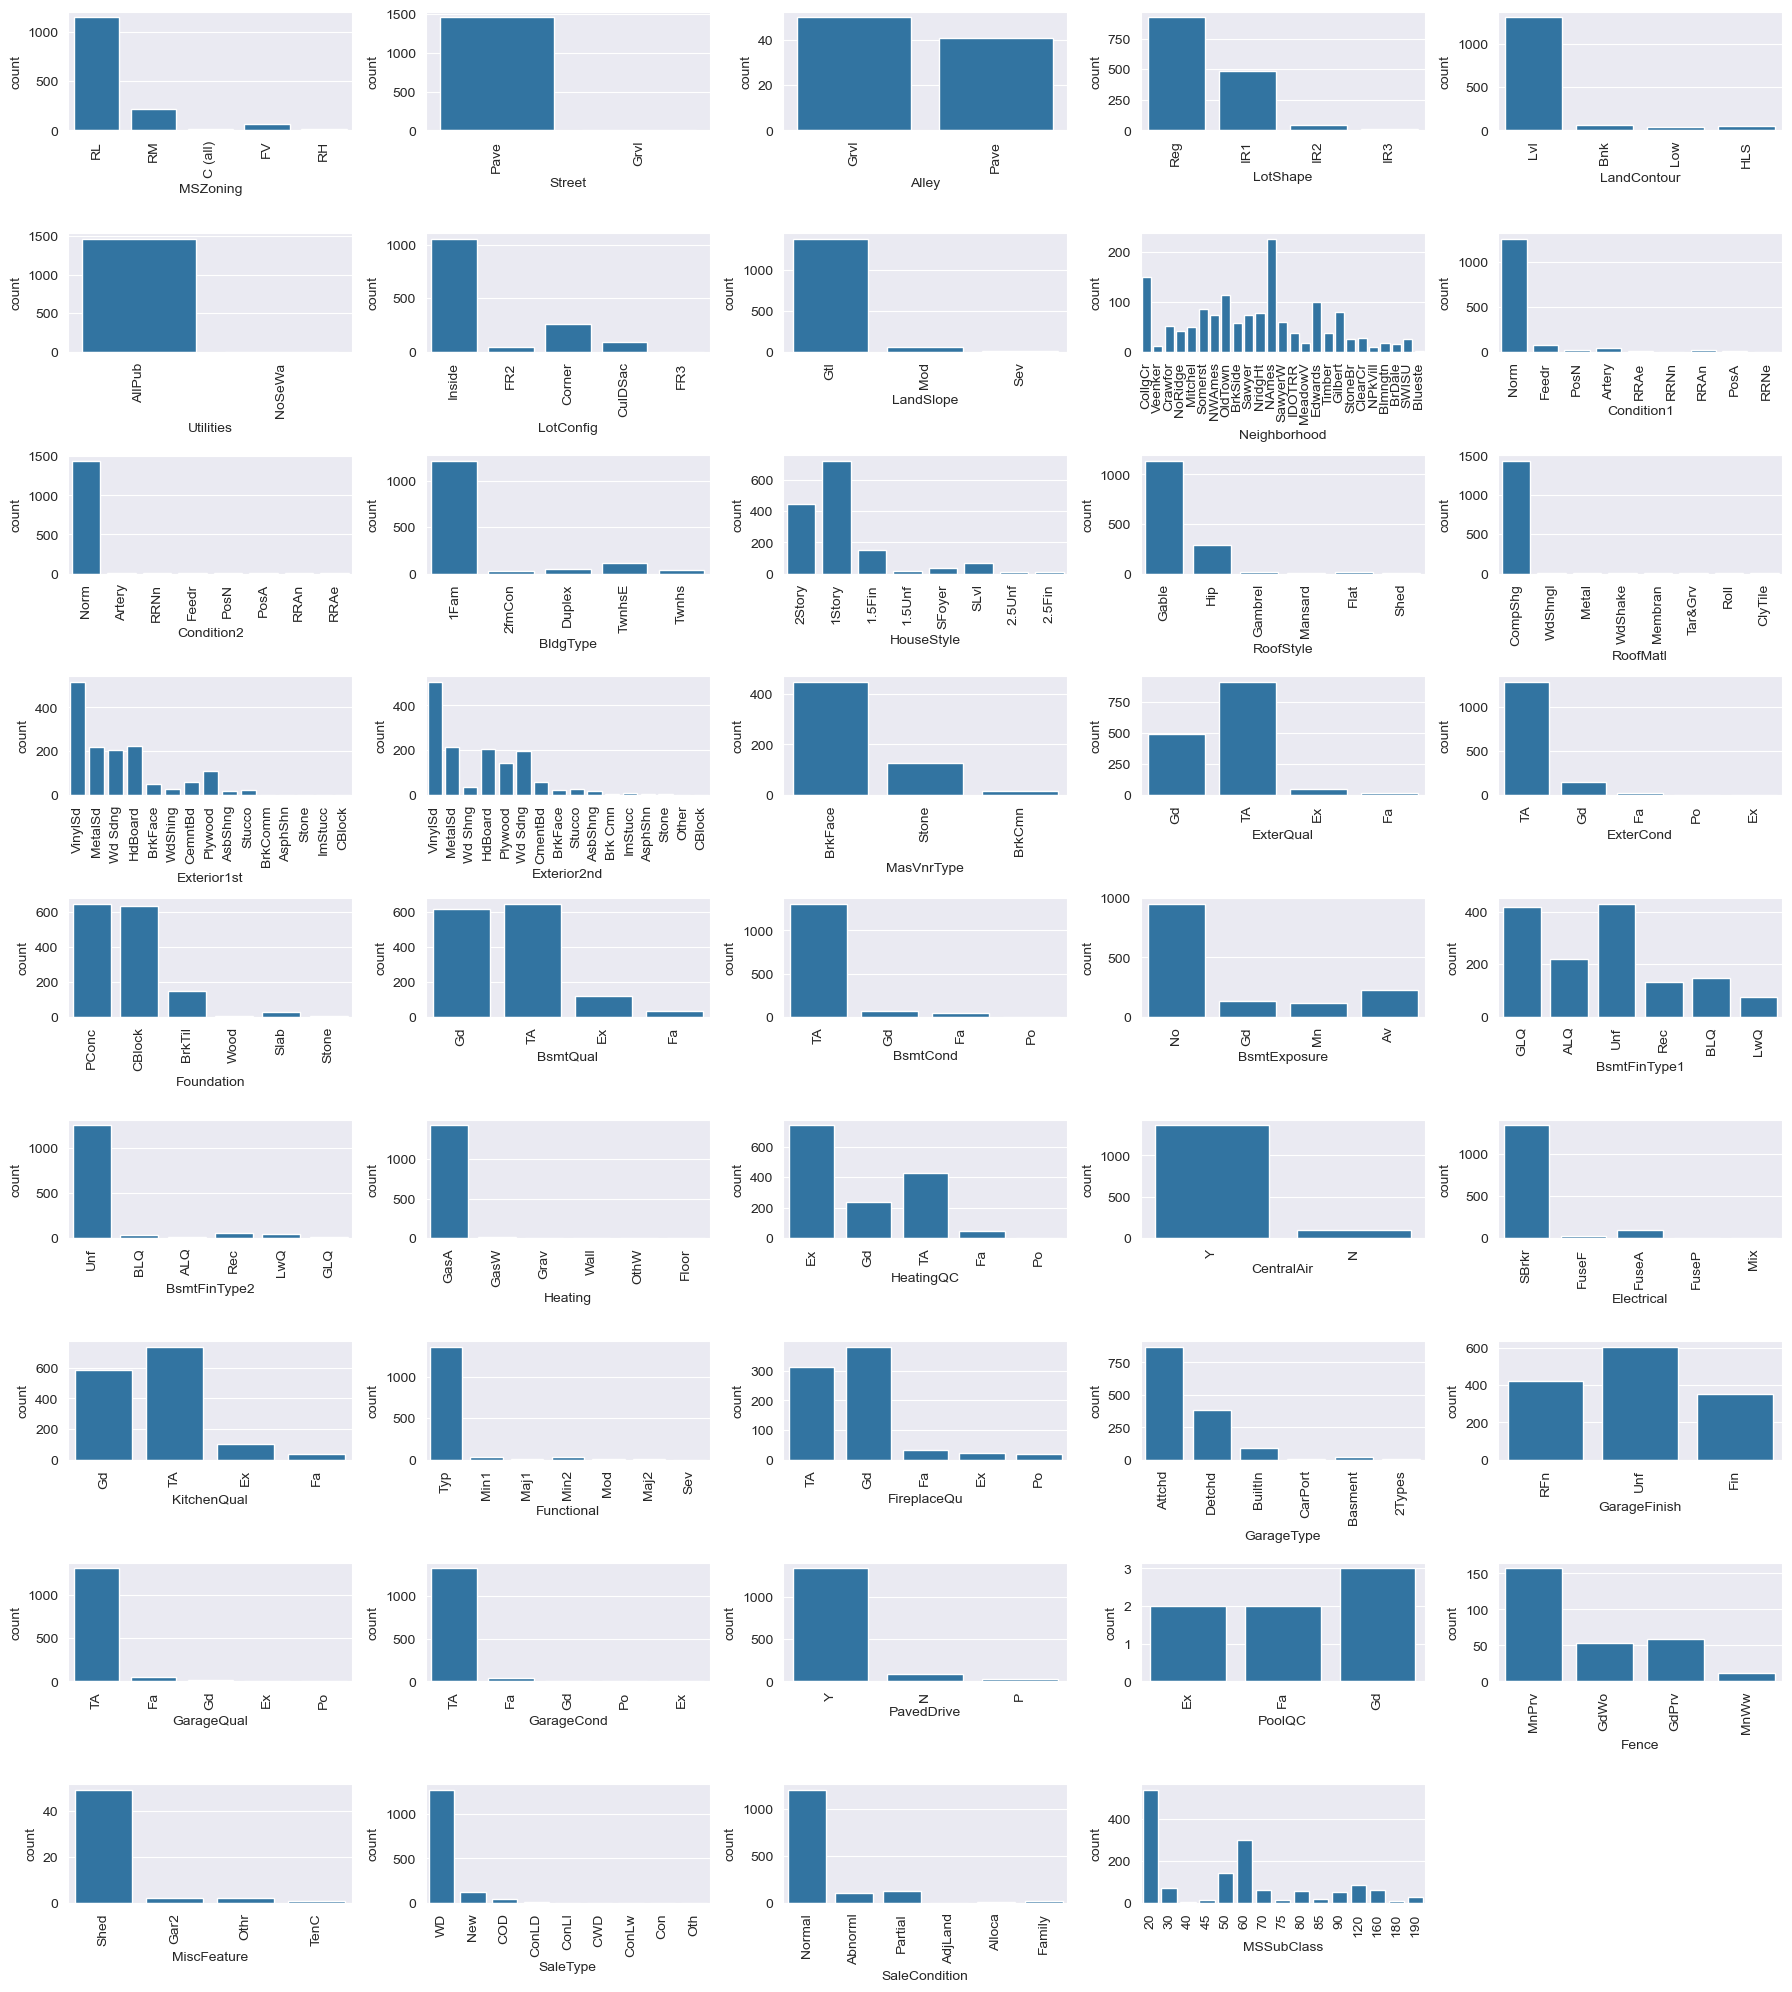

In [200]:
#plot for categorical, We can see that some categorical features like Utilities, Condition2 
# consist of mainly just one value, which does not add any useful information. Thus, we will also remove them later on.
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_train.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_train.iloc[:,index], data=cat_train.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

IndexError: single positional indexer is out-of-bounds

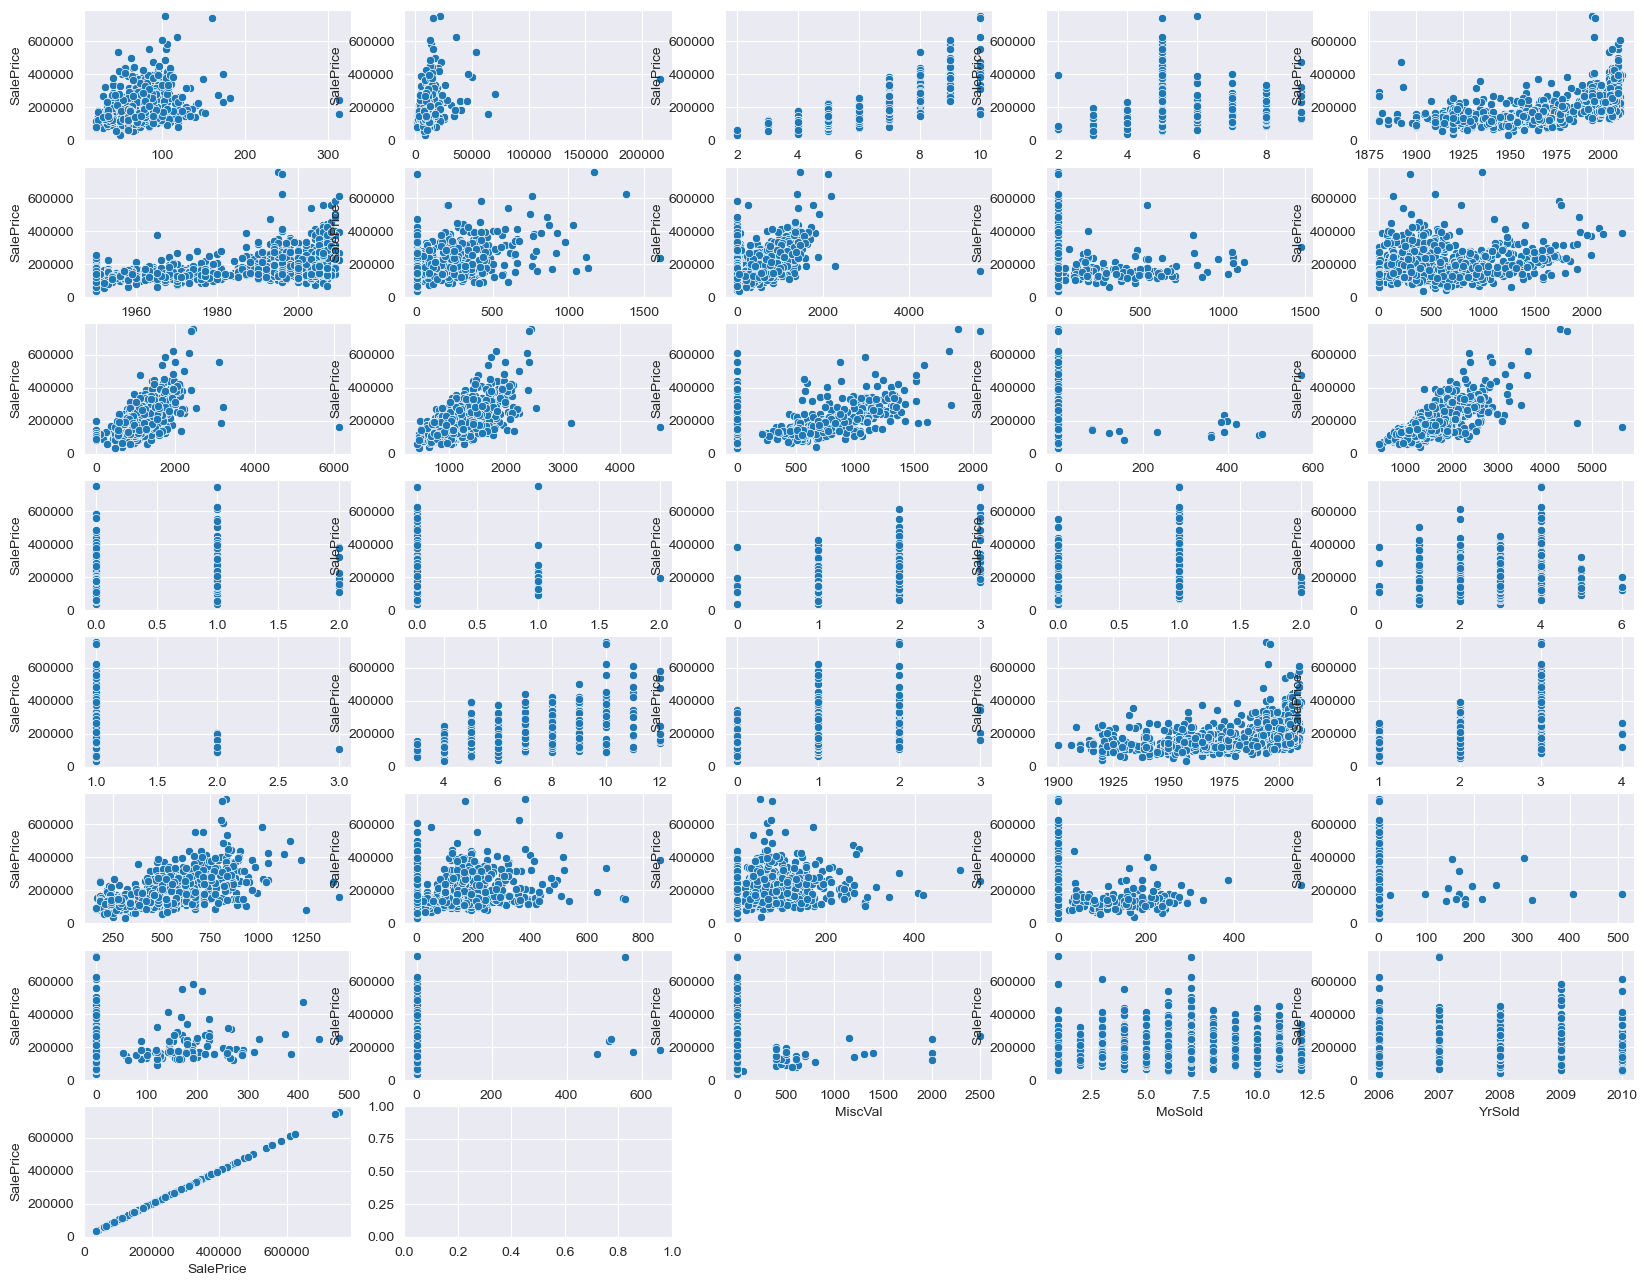

In [201]:
#scatter plot to determine 
fig = plt.figure(figsize=(20,20))
for index in range(len(X.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=numeric_c.iloc[:,index], y='SalePrice', data=numeric_c.dropna())
fig.tight_layout(pad=1.0)

<Axes: >

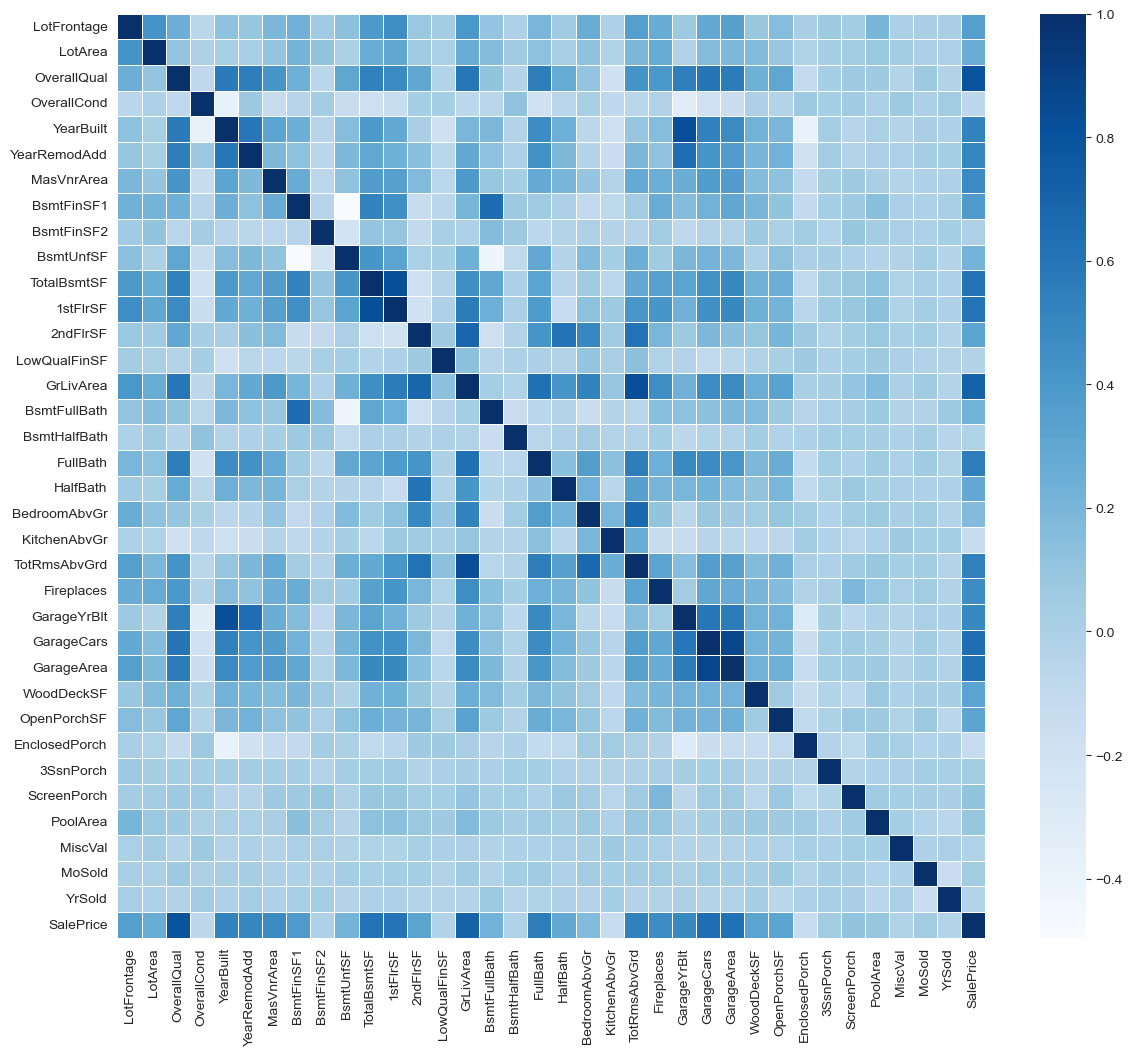

In [202]:
#to identify correlated variables we do correaltion matrix,
# Correlation not only allow us to determine which features are important to Saleprice, 
# but also as a mean to investigate any multicollinearity between our independent predictors.
plt.figure(figsize=(14,12))
correlation = numeric_c.corr()
sns.heatmap(correlation,  linewidth=0.5, cmap='Blues')

In [203]:
numeric_train = X.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [204]:
#from the correlation matrix we see mthat we have a probelm
# with multicollinarity of :GarageYrBlt and YearBuilt ,TotRmsAbvGrd and GrLivArea, 1stFlrSF and TotalBsmtSF, GarageArea and GarageCars
X.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


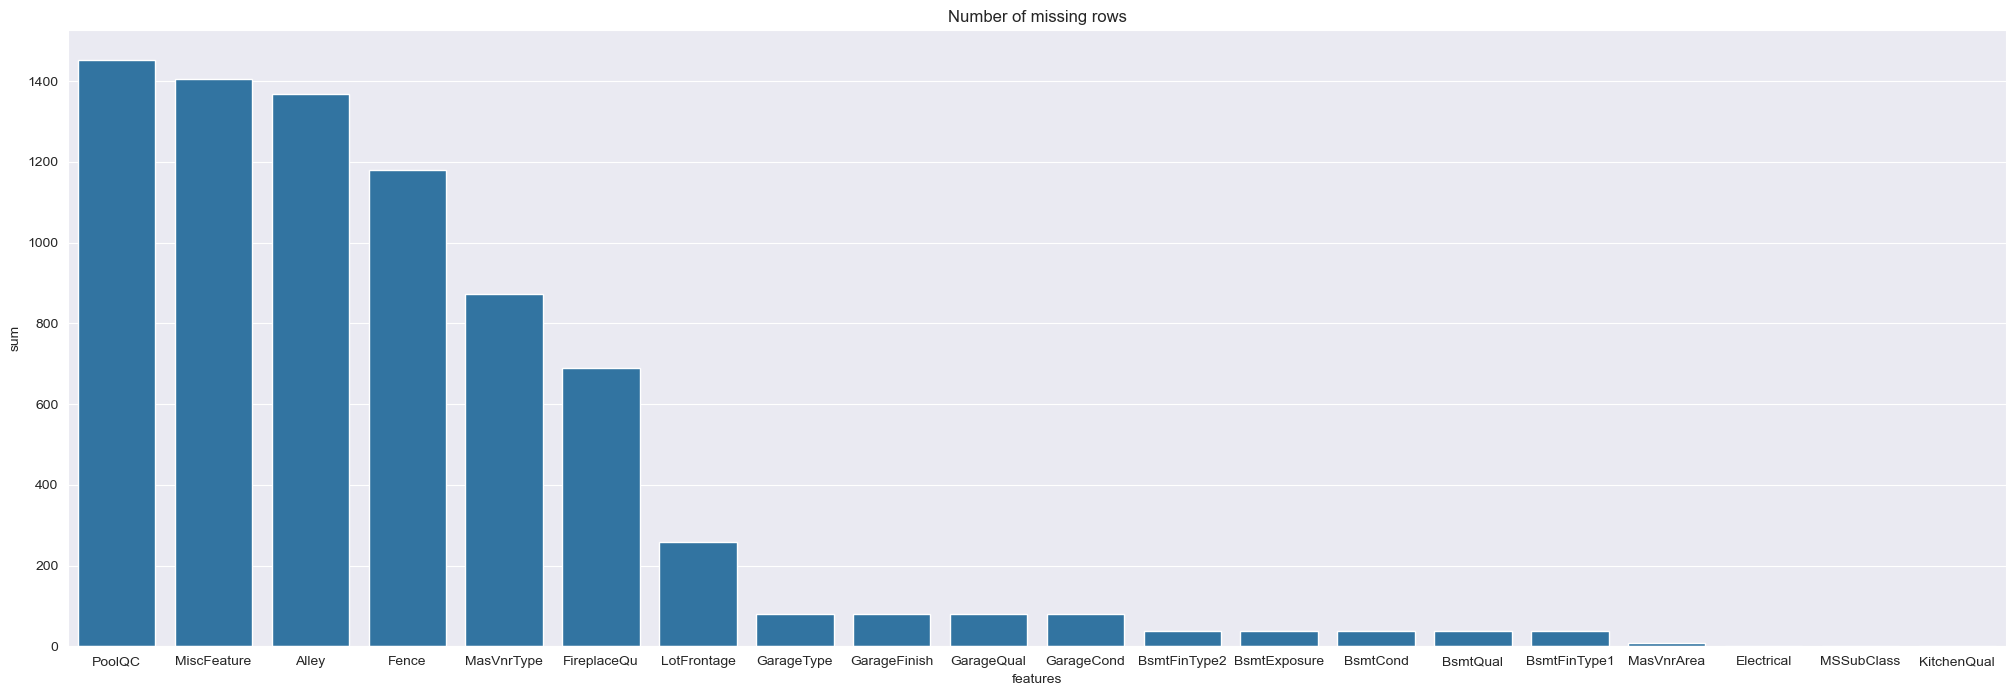

In [205]:
#now we get the values that have a lot of missing values
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)

# Number of missing values in each column 
missing_val_count_by_column = (X.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

In [206]:
#we remove the ones 
X.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

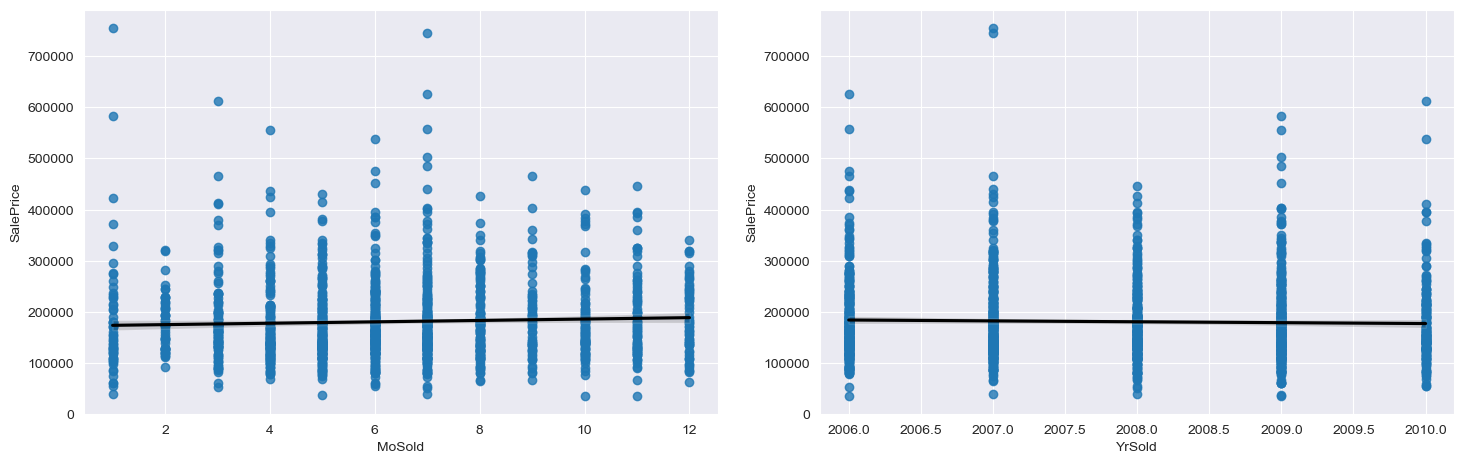

In [207]:
#we remove Useless features in predicting SalePrice- from the plots, 
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(x=numeric_train['MoSold'], y='SalePrice', data=numeric_train, ax = axes[0], line_kws={'color':'black'})
sns.regplot(x=numeric_train['YrSold'], y='SalePrice', data=numeric_train, ax = axes[1],line_kws={'color':'black'})
fig.tight_layout(pad=2.0)
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False).tail(10)

X.drop(['MoSold','YrSold'], axis=1, inplace=True)


In [208]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X[col].nunique(), X.columns))
d = dict(zip(X.columns, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('MasVnrType', 3),
 ('BsmtHalfBath', 3),
 ('HalfBath', 3),
 ('GarageFinish', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('BsmtQual', 4),
 ('BsmtCond', 4),
 ('BsmtExposure', 4),
 ('BsmtFullBath', 4),
 ('FullBath', 4),
 ('KitchenAbvGr', 4),
 ('KitchenQual', 4),
 ('Fireplaces', 4),
 ('Fence', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Electrical', 5),
 ('FireplaceQu', 5),
 ('GarageQual', 5),
 ('GarageCond', 5),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('BsmtFinType1', 6),
 ('BsmtFinType2', 6),
 ('Heating', 6),
 ('GarageType', 6),
 ('SaleCondition', 6),
 ('Functional', 7),
 ('Condition2', 8),
 ('HouseStyle', 8),
 ('RoofMatl', 8),
 ('BedroomAbvGr', 8),
 ('PoolArea', 8),
 ('Condition1', 9),
 ('OverallCond', 9),
 ('SaleType', 9),
 ('OverallQual', 10),
 ('MSSubClass', 15),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('3SsnPo

In [209]:
# deleting the rows with less than 96% unique values

threshold = 0.96
low_variance_columns = [col for col in X.columns if X[col].value_counts(normalize=True).iloc[0] > threshold]

# Drop these columns from the DataFrame
X = X.drop(columns=low_variance_columns)
print("Low Variance Columns:", low_variance_columns)


Low Variance Columns: ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', 'GarageCond', '3SsnPorch', 'PoolArea', 'MiscVal']


In [210]:
#For the moment, assume that PoolQC to Bsmt attributes are missing as the houses do not have them 
# (pools, basements, etc.). Hence, the missing values could be filled in with "None".


cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1' 
       ,'GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']
for i in cat:
    X[i] = X[i].fillna("None")



#MasVnrType has 8 missing values, the same number as missing MasVnrArea values. 
# Likely not to have masonry veneer. Hence, fill with 'None'
X.MasVnrArea = X.MasVnrArea.fillna(0)


In [211]:
#columns which are ordinal by nature, which represents the quality or condition of certain housing features. In this case, we will map the respective strings to a value. 
# The better the quality, the higher the value
# 
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual', 'FireplaceQu']
fin_col = ['BsmtFinType1','BsmtFinType2']

for col in ord_col:
     X[col] = X[col].map(ordinal_map)

for col in fin_col:
      X[col] = X[col].map(fintype_map)

X['BsmtExposure'] = X['BsmtExposure'].map(expose_map)




In [212]:
# Feature Engineering is a technique by which we create new features that could potentially aid in predicting our target variable. 
# Based on the current feature we have, the first additional featuire we can add would be TotalLot, which sums up both the LotFrontage 
# and LotArea to identify the total area of land available as lot. We can also calculate the total number of surface area of the house, 
# TotalSF by adding the area from basement and 2nd floor. TotalBath can also be used to tell us in total how many bathrooms are there in 
# the house. We can also add all the different types of porches around the house and generalise into a total porch area, TotalPorch.


X['TotalLot'] = X['LotFrontage'] + X['LotArea']
X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + X['HalfBath']
X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['ScreenPorch']

In [213]:
#Transforming binary columns
column = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

for col in column:
    col_name = col+'_bin'
    X[col_name] = X[col].apply(lambda x: 1 if x > 0 else 0)


/var/folders/jh/x3pzkf253nz6__d6tfg4p4200000gn/T/ipykernel_2261/465933998.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  dist = sns.distplot(X['SalePrice'],norm_hist=False)


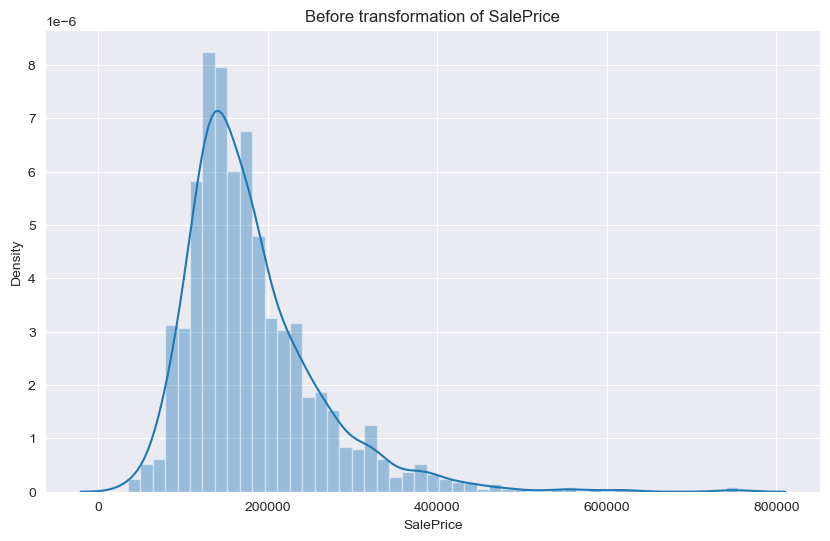

In [214]:
#we plot the dependant variable
plt.figure(figsize=(10,6))
plt.title("Before transformation of SalePrice")
dist = sns.distplot(X['SalePrice'],norm_hist=False)

/var/folders/jh/x3pzkf253nz6__d6tfg4p4200000gn/T/ipykernel_2261/2846594855.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  dist = sns.distplot(np.log(X['SalePrice']),norm_hist=False)


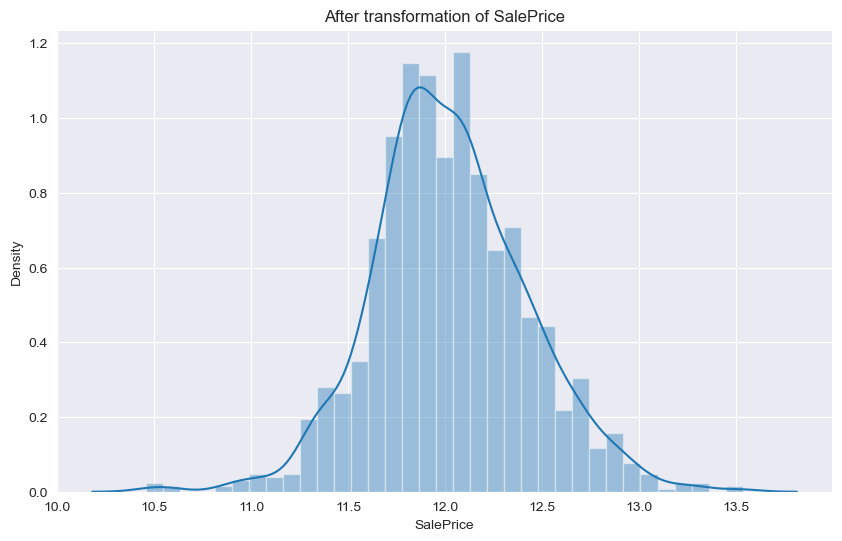

In [215]:
#we see is skewed to the right, where the tail on the curve’s right-hand side is longer than the tail on the left-hand side, 
# and the mean is greater than the mode - postive skewness
#soulution: log transformation
plt.figure(figsize=(10,6))
plt.title("After transformation of SalePrice")
dist = sns.distplot(np.log(X['SalePrice']),norm_hist=False)

y["SalePrice"] = np.log(y['SalePrice'])
#we drop SalePrice from X
X.drop(['SalePrice'], axis=1, inplace=True)

In [216]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y["SalePrice"], test_size=0.2, random_state=42)

In [218]:
# from  boxplots we see outliers that we need to remove
# Identify outlier indices
outlier_indices = X_train[(X_train['LotFrontage'] > 200) | 
                           (X_train['LotArea'] > 100000) | 
                           (X_train['BsmtFinSF1'] > 4000) | 
                           (X_train['TotalBsmtSF'] > 5000) | 
                           (X_train['GrLivArea'] > 4000)].index

# Remove outliers from both X_train and y_train
X_train = X_train.drop(outlier_indices)
y_train = y_train.drop(outlier_indices)

In [219]:
# Separate the numeric and non-numeric columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns


In [220]:
# Define the transformers for numeric and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])
#The Pipeline function in scikit-learn is used to streamline a sequence of data processing steps.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [221]:

# Define model pipelines 
pipelines = {
    'Lasso': Pipeline(steps=[('preprocessor', preprocessor), ('model', Lasso(random_state=42))]),
    'LinearRegression': Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())]),
    'GradientBoostingRegressor': Pipeline(steps=[('preprocessor', preprocessor), ('model', GradientBoostingRegressor(random_state=42))]),
    'XGBRegressor': Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBRegressor(random_state=42))]),
   # 'LGBMRegressor': Pipeline(steps=[('preprocessor', preprocessor), ('model', LGBMRegressor(random_state=42))]),
    'CatBoostRegressor': Pipeline(steps=[('preprocessor', preprocessor), ('model', CatBoostRegressor(random_state=42, verbose=0))])
}



In [222]:
# Evaluate models with cross_val_score
def evaluate_models(pipelines, X, y):
    results = []
    for model_name, pipeline in pipelines.items():
        scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
        results.append({
            'Model': model_name,
            'Mean MAE': -scores.mean(),
            'Std Dev': scores.std()
        })
        print(f'Model: {model_name}, Mean MAE: {-scores.mean():.4f}, Std Dev: {scores.std():.4f}')
    return pd.DataFrame(results)

initial_results_df = evaluate_models(pipelines, X_train, y_train)
print("Initial Model Assessment Results:")
print(initial_results_df)

Model: Lasso, Mean MAE: 0.2970, Std Dev: 0.0188
Model: LinearRegression, Mean MAE: 92119.8690, Std Dev: 87174.3842
Model: GradientBoostingRegressor, Mean MAE: 0.0865, Std Dev: 0.0071
Model: XGBRegressor, Mean MAE: 0.0948, Std Dev: 0.0086
Model: CatBoostRegressor, Mean MAE: 0.0792, Std Dev: 0.0048
Initial Model Assessment Results:
                       Model      Mean MAE       Std Dev
0                      Lasso      0.296965      0.018847
1           LinearRegression  92119.869014  87174.384249
2  GradientBoostingRegressor      0.086533      0.007065
3               XGBRegressor      0.094752      0.008649
4          CatBoostRegressor      0.079210      0.004783


In [223]:
# Select top models based on the initial evaluation
top_models = initial_results_df.nsmallest(3, 'Mean MAE')['Model'].tolist()
print("Top Models Selected for Hyperparameter Tuning:", top_models)

Top Models Selected for Hyperparameter Tuning: ['CatBoostRegressor', 'GradientBoostingRegressor', 'XGBRegressor']


In [246]:
# Define parameter grids for GridSearchCV
param_grids = {
    'Lasso': {'model__alpha': [0.1, 1, 10]},
    'GradientBoostingRegressor': {
        'model__n_estimators': [100, 500, 1000],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 6, 9]
    },
    'XGBRegressor': {
        'model__n_estimators': [100, 500, 1000],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 6, 9]
    },
    'LGBMRegressor': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 6, 9]
    },
    'CatBoostRegressor': {
        'model__iterations': [100, 500, 1000],
        'model__learning_rate': [ 0.01, 0.1,0.2],
        'model__depth': [3, 6, 9]
        
    }
}


In [247]:
# Perform GridSearchCV for the selected top models
def tune_models(pipelines, param_grids, top_models, X, y):
    tuning_results = []
    for model_name in top_models:
        pipeline = pipelines[model_name]
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X, y)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = -grid_search.best_score_
        tuning_results.append({'Model': model_name, 'Best Parameters': best_params, 'Best Score': best_score})
        print(f'Model: {model_name}, Best Params: {best_params}, Best Score: {best_score:.4f}')
    return pd.DataFrame(tuning_results)

tuning_results_df = tune_models(pipelines, param_grids, top_models, X_train, y_train)
print("Hyperparameter Tuning Results:")
print(tuning_results_df)

Model: CatBoostRegressor, Best Params: {'model__depth': 3, 'model__iterations': 1000, 'model__learning_rate': 0.1}, Best Score: 0.0803
Model: GradientBoostingRegressor, Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 500}, Best Score: 0.0840
Model: XGBRegressor, Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 500}, Best Score: 0.0847
Hyperparameter Tuning Results:
                       Model  \
0          CatBoostRegressor   
1  GradientBoostingRegressor   
2               XGBRegressor   

                                     Best Parameters  Best Score  
0  {'model__depth': 3, 'model__iterations': 1000,...    0.080293  
1  {'model__learning_rate': 0.1, 'model__max_dept...    0.084025  
2  {'model__learning_rate': 0.1, 'model__max_dept...    0.084721  


In [248]:
# Evaluate the best models on the test dataset
def evaluate_on_test(pipelines, X_train, y_train, X_test, y_test):
    test_results = []
    for model_name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)  # Fit on the training data
        y_pred = pipeline.predict(X_test)
        test_score = -pipeline.score(X_test, y_test)  # Negative MAE
        mae = mean_absolute_error(y_test, y_pred)
        mse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_results.append({
            'Model': model_name, 
            'Test Score': test_score,
            'Test MSE': mse,
            'test mae': mae})
    return pd.DataFrame(test_results)

test_results_df = evaluate_on_test(pipelines, X_train, y_train,X_test, y_test)


# Combine and display the results in a single table
final_results_df = initial_results_df.merge(tuning_results_df, on='Model', how='left', suffixes=('_Initial', '_Tuned'))
final_results_df = final_results_df.merge(test_results_df, on='Model', how='left')

print("Final Results:")
print(final_results_df)

Final Results:
                       Model      Mean MAE       Std Dev  \
0                      Lasso      0.296965      0.018847   
1           LinearRegression  92119.869014  87174.384249   
2  GradientBoostingRegressor      0.086533      0.007065   
3               XGBRegressor      0.094752      0.008649   
4          CatBoostRegressor      0.079210      0.004783   

                                     Best Parameters  Best Score  \
0                                                NaN         NaN   
1                                                NaN         NaN   
2  {'model__learning_rate': 0.1, 'model__max_dept...    0.084025   
3  {'model__learning_rate': 0.1, 'model__max_dept...    0.084721   
4  {'model__depth': 3, 'model__iterations': 1000,...    0.080293   

     Test Score      Test MSE     test mae  
0 -1.084263e-02      0.429640     0.332804  
1  8.918523e+09  40796.040695  2387.492185  
2 -9.034841e-01      0.134206     0.089220  
3 -8.854666e-01      0.146197     0